## <span style="color: blue;">360° 4K Virtual Reality Deep Dream Fractal Tutorial</span>
Hello friends of computer generated images,<br>
<br>
I am a fractal explorer for many years and publish **3D fractal** animations created with **Mandelbulb 3D** at my YouTube channel:<br>
https://www.youtube.com/user/schizo604<br>
<br>
Beside my fascination for fractals I also love the trippy images that you can create using the **google Deep Dream** algorithm. So the direction was clear: combine them! ;-)<br>
But I thought: When you want to do it, then go big and do something new! So I didn't choose a normal animation as the fractal source but I used a 4K 360° fractal as the source animation. That wasn't easy and took a lot of experiments and programming in python.<br>
<br>
The result of this work is my video "Acid Eye" that exist in 3 versions:<br>
[Acid Eye - 360° Animation Version](https://www.youtube.com/watch?v=MaTQYFG_pb8)<br>
[Acid Eye - 4K flat Animation Version](https://www.youtube.com/watch?v=SyAnEOBOw9Y)<br>
[Acid Eye - Slideshow Version](https://www.youtube.com/watch?v=DtRjOSAvSNA)<br>
<br>
Problems I had to solve:<br>
<ul>
<li>rendering 4K images via CPU is too slow - solution: use google deep dream with CUDA support so my GeForce GTX 970 could do the work much faster
<li>deep dreaming of 4K images wasn't possible because of memory problems (neural networks need a lot of RAM) - solution: for the final 4K dreaming do a lot of randomly selected 400x400 pixel dream squares
<li>keep also the fine 4K dream details stable during the animation so it doesn't flicker so much - solution: do some additional blending at the right time
<li>use various deep dream inception modes but blend them smoothly - solution: start the dreaming of the second animation already based on a fading sequence from the first animation and do some addition blending
<li>we have a 360° video, so dream at left side should match to dream at right side - solution: copy a left stripe to the right and a right stripe to the left, dream, blend and crop to original size
<li>we have a 360° video, but you can't dream top and bottom correct - solution: blend top and bottom to black
</ul>
<br>
Below you find the python code that I used to create the animation. Black is the original google Deep Dream notebook. Blue text and following code block is my additional description+code.<br>
<br>
**Acknowledgments:**<br>
Thank you Alex [Mischlichter](https://www.youtube.com/user/funkybrown81) for fantastic postprocessing of the animation.<br>
<br>
Thank you google dream team for the crazy idea and sharing the code.<br>
<br>
Thank you Joseph Smarr for the ["Dreaming big" blog post](http://josephsmarr.com/2016/02/09/dreaming-big/) that made **4K rendering** possible.<br>
<br>
Thank you Brian T. for the great post and all the files that help me to get [**google Deep Dream running on my Windows 10 machine with CUDA support**](http://web.archive.org/web/20160514042407/http://thirdeyesqueegee.com:80/deepdream/). That blog post no longer exist :-( But you can still view it via archive.org:<br>
http://web.archive.org/web/20160514042407/http://thirdeyesqueegee.com:80/deepdream/<br>
I used the "Easy way" method:<br>
http://web.archive.org/web/20160514041031/http://thirdeyesqueegee.com:80/deepdream/2015/07/19/running-googles-deep-dream-on-windows-with-or-without-cuda-the-easy-way/<br>
<br>
The mega.nz links at this guide still work, but you have to remove the archive.org prefix:<br>
CPU_ONLY version of Caffe: https://mega.co.nz/#!GVpW0LZJ!Orwv9g_oYvTRvvq2Lzb-jDszvrqh334wCepQqMx8QPo<br>
CUDA v7.5 enabled version of Caffe (I used that one): https://mega.nz/#!aURgBaoA!rg77CExAjyLFUdsIJHdauBXjJHAx_CT5I9LcRYP4V2M<br>
CUDA v7.0 Caffe: https://mega.co.nz/#!GZ4GWApJ!XSutQ3D-zHkGxFi2FlDpqjuB73VghGtHdjdjAPxPH8A<br>
Essential 3rd Party Addons: https://mega.co.nz/#!OEJCDbKA!7ni3fPeQJFBouwe9izrLW4MNQHYSEUpG1ZL7vXBCPXs<br>
<br>

**Contact:**<br>
You can contact me via schizo@[psykick.de](http://www.psykick.de)<br>
<br>
Enjoy this code tutorial. Hope it helps to realize your own projects.<br>
<br>
18.September 2017


# Deep Dreams (with Caffe)

This notebook demonstrates how to use the [Caffe](http://caffe.berkeleyvision.org/) neural network framework to produce "dream" visuals shown in the[Google Research blog post](http://googleresearch.blogspot.ch/2015/06/inceptionism-going-deeper-into-neural.html).

It'll be interesting to see what imagery people are able to generate using the described technique. If you post images to Google+, Facebook, or Twitter, be sure to tag them with **#deepdream** so other researchers can check them out too.

## Dependencies
This notebook is designed to have as few dependencies as possible:
* Standard Python scientific stack: [NumPy](http://www.numpy.org/), [SciPy](http://www.scipy.org/), [PIL](http://www.pythonware.com/products/pil/), [IPython](http://ipython.org/). Those libraries can also be installed as a part of one of the scientific packages for Python, such as [Anaconda](http://continuum.io/downloads) or [Canopy](https://store.enthought.com/).
* [Caffe](http://caffe.berkeleyvision.org/) deep learning framework ([installation instructions](http://caffe.berkeleyvision.org/installation.html)).
* Google [protobuf](https://developers.google.com/protocol-buffers/) library that is used for Caffe model manipulation.

## <span style="color: blue;">schizo604:</span>
<span style="color: blue;">Import and basic setup nearly unchangend.
Just added the import of *PIL.ImageOps* for some additional image operations.</span>

In [1]:
# imports and basic notebook setup
from cStringIO import StringIO
import numpy as np
import scipy.ndimage as nd
import PIL.Image
import PIL.ImageOps         #added by schizo604
from IPython.display import clear_output, Image, display
from google.protobuf import text_format

import caffe

caffe.set_device(0)
caffe.set_mode_gpu()

def showarray(a, fmt='jpeg'):
    a = np.uint8(np.clip(a, 0, 255))
    f = StringIO()
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))


## Loading DNN model
In this notebook we are going to use a [GoogLeNet](https://github.com/BVLC/caffe/tree/master/models/bvlc_googlenet) model trained on [ImageNet](http://www.image-net.org/) dataset.
Feel free to experiment with other models from Caffe [Model Zoo](https://github.com/BVLC/caffe/wiki/Model-Zoo). One particularly interesting [model](http://places.csail.mit.edu/downloadCNN.html) was trained in [MIT Places](http://places.csail.mit.edu/) dataset. It produced many visuals from the [original blog post](http://googleresearch.blogspot.ch/2015/06/inceptionism-going-deeper-into-neural.html).

## <span style="color: blue;">schizo604:</span>
<span style="color: blue;">No changes.</span>

In [2]:
model_path = './caffe/models/bvlc_googlenet/' # substitute your path here
net_fn   = model_path + 'deploy.prototxt'
param_fn = model_path + 'bvlc_googlenet.caffemodel'

# Patching model to be able to compute gradients.
# Note that you can also manually add "force_backward: true" line to "deploy.prototxt".
model = caffe.io.caffe_pb2.NetParameter()
text_format.Merge(open(net_fn).read(), model)
model.force_backward = True
open('tmp.prototxt', 'w').write(str(model))

net = caffe.Classifier('tmp.prototxt', param_fn,
                       mean = np.float32([104.0, 116.0, 122.0]), # ImageNet mean, training set dependent
                       channel_swap = (2,1,0)) # the reference model has channels in BGR order instead of RGB

# a couple of utility functions for converting to and from Caffe's input image layout
def preprocess(net, img):
    return np.float32(np.rollaxis(img, 2)[::-1]) - net.transformer.mean['data']
def deprocess(net, img):
    return np.dstack((img + net.transformer.mean['data'])[::-1])


##  Producing dreams

Making the "dream" images is very simple. Essentially it is just a gradient ascent process that tries to maximize the L2 norm of activations of a particular DNN layer. Here are a few simple tricks that we found useful for getting good images:
* offset image by a random jitter
* normalize the magnitude of gradient ascent steps
* apply ascent across multiple scales (octaves)

First we implement a basic gradient ascent step function, applying the first two tricks:

## <span style="color: blue;">schizo604:</span>
<span style="color: blue;">Disabled the Jitter-shift and Jitter-unshift. I have no clue what their function is and dreaming works well without the shift. I disabled it, because the Jitter-shift is random, but I want a deterministic dream sequence that is reproducable. More on that later.</span>

In [3]:
def objective_L2(dst):
    dst.diff[:] = dst.data 

def make_step(net, step_size=1.5, end='inception_4c/output', 
              jitter=0, clip=True, objective=objective_L2):
    '''Basic gradient ascent step.'''

    src = net.blobs['data'] # input image is stored in Net's 'data' blob
    dst = net.blobs[end]

    # Jitter-shift disabled because I want a deterministic instead of a random calculation (schizo604)
    #ox, oy = np.random.randint(-jitter, jitter+1, 2)
    #src.data[0] = np.roll(np.roll(src.data[0], ox, -1), oy, -2) # apply jitter shift
            
    net.forward(end=end)
    objective(dst)  # specify the optimization objective
    net.backward(start=end)
    g = src.diff[0]
    # apply normalized ascent step to the input image
    src.data[:] += step_size/np.abs(g).mean() * g

    # Jitter-unshift disabled (schizo604)
    #src.data[0] = np.roll(np.roll(src.data[0], -ox, -1), -oy, -2) # unshift image
            
    if clip:
        bias = net.transformer.mean['data']
        src.data[:] = np.clip(src.data, -bias, 255-bias)


Next we implement an ascent through different scales. We call these scales "octaves".

## <span style="color: blue;">schizo604:</span>
<span style="color: blue;">No changes. Maybe you want to disable the output via showarray and print octave...<br>
My main create_dreamsequence method calls this deepdream method from each of the 3 size levels. Only level 1 uses 4 octaves, level 2 and 3 just do an 1 octave run.
</span>

In [4]:
def deepdream(net, base_img, iter_n=1, octave_n=1, octave_scale=1.4, 
              end='inception_4c/output', clip=True, **step_params):
    # prepare base images for all octaves
    octaves = [preprocess(net, base_img)]
    for i in xrange(octave_n-1):
        octaves.append(nd.zoom(octaves[-1], (1, 1.0/octave_scale,1.0/octave_scale), order=1))
    
    src = net.blobs['data']
    detail = np.zeros_like(octaves[-1]) # allocate image for network-produced details
    for octave, octave_base in enumerate(octaves[::-1]):
        h, w = octave_base.shape[-2:]
        if octave > 0:
            # upscale details from the previous octave
            h1, w1 = detail.shape[-2:]
            detail = nd.zoom(detail, (1, 1.0*h/h1,1.0*w/w1), order=1)

        src.reshape(1,3,h,w) # resize the network's input image size
        src.data[0] = octave_base+detail
        for i in xrange(iter_n):
            make_step(net, end=end, clip=clip, **step_params)
            
            # visualization
            vis = deprocess(net, src.data[0])
            if not clip: # adjust image contrast if clipping is disabled
                vis = vis*(255.0/np.percentile(vis, 99.98))
            showarray(vis)
            print octave, i, end, vis.shape
            clear_output(wait=True)
            
        # extract details produced on the current octave
        detail = src.data[0]-octave_base
    # returning the resulting image
    return deprocess(net, src.data[0])

## <span style="color: blue;">schizo604:</span>
<span style="color: blue;">Thats all what I used from the google source. Rest is own code. Keep in mind that this is my first python project. So my programming skills in this language are quite low.</span>

## <span style="color: blue;">schizo604:</span>
<span style="color: blue;">This helper method initializes the random generator. I call this at the beginning and between I flip the inception modes. That way I get a deterministic behavior, so each time I start the process the result will be the same. The call between flip of the inception modes has the advantage that you can stop rendering between two inception modes and continue rendering later in a deterministic way.</span>

In [5]:
def set_random_generator():
  #set the random generator to a specific state
  #that way the random squares at level 2 and 3 are reproducable and so the whole process is completly reproducable
  np.random.set_state(('MT19937', np.array([2297312705, 1453397806, 4200874952, 4118173674, 1392369054,
           725667893, 2623111879,  480086086, 3982896810, 1892768155,
          1771591696, 1626126598, 2283837401, 1333779843, 3586079799,
          2544476336, 2088392727,  781136344, 2273213859, 2866561655,
           248664441, 1407266370,  458423884, 2160885073, 1861102777,
          2423130873, 1881185878, 1953358291, 1230230601, 1968415233,
           370458014,  471066235, 3404056452, 3294180749, 2696137284,
          3313613445, 3353459892, 2921877106,  451945892, 1902600417,
          3612216894,  962956911, 2228279223, 2809369858,  547021836,
          2540920032,  142644479, 1330306474, 1595546947, 3715777707,
          1291763300,  362173580, 2235041187, 4063917184, 2259378702,
          3672130258, 1153858289, 3814159315, 3590222987, 3346065844,
          1599703692, 2511522678, 3476033975, 3111362066, 2613693866,
           717854071, 3763970939, 3795878024, 2031740058,  653464232,
          2205534461, 3710605278, 2745546134, 1045942392, 4252774681,
          4060093238, 3353291177, 2903056569, 1486033078, 3454526456,
          3597122104, 4080903564,  740429396,  910322747, 1478727663,
          1400657588,  198069068, 1929023254, 2744929207,  516885132,
          3074600292, 3485585362, 3055364510,  940954295, 1808439325,
           886483364, 2041347205, 3858332544, 1919687939, 1828495203,
           903591595,   67321545,   82195437, 2895823036, 1128473196,
          2303188425, 2069616950, 1166964762, 1722662310, 1654046372,
          1898165950, 2614881028, 1194392980, 3284866657, 1518434732,
          2469615023, 3366226265, 1005657738, 3426598797, 3723004237,
          2752280128,  875276346, 1698325679,  195895996, 1625570812,
          3936494579, 1571307313, 1154845336,  930152756, 4073179352,
           301663193, 2823863574, 1429443560,   89814709, 2807919281,
           287383653, 2790809496, 2163302007, 1556901602,  420095854,
          1309446145, 1719074620, 1616555531, 1388636777, 1876071901,
          4057555641, 2313328519, 1468169792, 4030537771,  106807711,
          3544683036, 3346188865, 1568934362, 3791392140, 3635792148,
          4251639619, 3252949051, 2235126310, 4001480366,  400573442,
          4270062421, 3728480574, 2307476704,  571593496,  856277450,
          4030332211, 3624327835, 2179771449, 3361730718, 3623101274,
          1594381418,  717258554,  902067753, 1362588972, 4226635740,
          2305035383, 1270994965, 3439195291,  518041789, 4043570688,
          4093819154, 3639185774, 2430935746, 2140518065, 2286074871,
          4204899682,  423369865, 2140801498, 3429573188, 1743345858,
          2636305625,   61911534, 2451489599, 2953025389,   15362107,
          3388270164, 3127154107, 3521467328, 1946821549, 3962589028,
          3205509963,  692001518, 1871991173,  370445386, 4281039732,
          1269917370, 3525791731, 2569957999, 1072698457, 3837046657,
          1130176883, 4164039173,  374251621, 2298751157,  904868336,
          4144573654, 2494945775, 1680476112,  942429035, 3067021090,
           398994990, 3804161526, 1895952644, 3541015575, 1896349480,
          4227863250, 2796769965, 1659659799, 2062034019, 2054909388,
           858230614,  402566804, 1963619911, 2757204907, 2705881514,
          1153276048, 4081214235, 1119011881, 3000239067, 2619074159,
          1156099096, 4055328022, 3305662852, 3756390266, 1224153551,
          3669458401,  429830676,   14346364, 2139647186, 2917437492,
          3191788877,  174056708, 2130815992,  257727973,  464831999,
          3824729860,  937598383,  470825876, 2121216129, 1093440293,
          2361362562, 2304898464, 3812509207, 2193650498, 3352396582,
           539268036,  835949262, 1713887333,  811099035, 4191989187,
          1063832174, 2333699351, 1493541283, 1344897173,  953922700,
          2931098221, 3129547285, 1481341086, 4053085273, 1030675627,
          3490876430, 3247440220, 1967822768, 1607406979, 3240450240,
          1864718127, 1666543894,   51134513, 2272081162,  340499746,
          3371275573, 2851766680, 4190918975,  251426333,   11596062,
           972164209, 1905320122, 3677803384, 4195296501,  269071620,
          4185632517, 4265218857, 1002216716, 2746200021, 4139820051,
           791089597, 3443484693, 1968573794,   16028908, 3939205583,
          3430417403, 2486529505, 4147487176, 2265346592,  202836748,
          2493795105,  563596991, 3473502688, 3775367236, 4088767075,
           285137382, 1464541540,  963042941, 3588876206,  738312270,
           336452624,  142382239, 1769534820, 3129257425, 1617150313,
          1869687685, 2247021262,  423087586, 2771273128, 2042510249,
          3786786304, 2810424918, 1201814793, 2212338448, 3910124909,
          1211436171,   75614655, 3843688812, 3793239777, 2698509368,
          1348329158,  536744106, 1015497784, 1902860496, 2345749456,
          3917642099, 2859792622, 1697183248, 2362106893, 1263553142,
          2236843702,  219704278, 2160656964, 1206135883, 4172536370,
          1710820805, 1372624030, 1150505081, 2575793954, 1237020310,
           582276108,  576256637, 1156764757, 2692657018,  545467224,
           306070240,  485310251, 2904479780,  732406766, 2479969171,
          2170553132, 4005333173, 3549624426,  312142681, 2501010012,
          3318207066, 2504508427, 3322735135,  767311821,  269825928,
           214831802, 3796281771, 4209165572, 3664471636, 4009672730,
          1856134787, 2993970309, 3480542981,  421157532, 1405475445,
           644516497, 3343207366,  659965942, 3876145260, 1084015929,
          3086346624, 3413648975, 3451714091, 2852431540,  420630047,
          2677631847, 3607780096, 4053905515, 1163441653, 1169083842,
          2031189495, 1755471624, 2414369713, 1051916145, 2237517984,
          2127531654, 2757114441, 3621416471, 2550533285,  168041236,
           981956393, 1607855857,  410365588, 2901482275, 3085547656,
          2323709153, 4112449399, 3967652549, 1028175137,  983774653,
          3089503730, 2105733447, 2175255124, 1894746386, 4209913858,
           539054664,   43011681,  219839298,  905625851, 1147980688,
          3898346329, 4192194893, 2122470768, 3397637636,  906466023,
          1845932026, 4276738311, 3975058868,  312026596, 1918453896,
          1749444548, 2152964900, 2782763338, 2623041584, 4064867330,
          3559058413,    2827292, 2654592190, 1129493741, 3889785096,
           834355565, 3530296638, 1225820441,  503814113, 3747826223,
           828206520, 3175981100, 4021045080,  642383848, 3844963553,
           108313653, 3581942700, 4135386654, 3769145819, 2272746485,
          3059798624, 3491589480,  272205567, 3859341893, 2904502431,
           534142982, 1471620478, 1526196939, 2822327019, 3713555569,
          1046438850, 1708647964, 1710102321, 1110418845, 3315295270,
           333629317, 2743269270,  721876181, 1094701814, 2926560367,
          1193002470,  626214731, 4230674975,  658501679,  340245869,
          1893386810,  398577451, 3989147215, 2668085727, 3125375677,
           159727500,  411141072, 3128806603, 4080936195, 2501660679,
          2178464095, 2168219601, 2984627755,   67909318, 1565849603,
          1794517117, 1581870203, 3869864498, 3623118971, 3767462074,
          2596243676, 2041475834, 2923725065, 2362357214, 1606119766,
          3819484724,  382143057, 2588690058, 3813643908, 1478659792,
          1015851283, 3492833235,  302593032, 3877251267, 2352917236,
          1217486867, 1634280224, 1108874011, 2924500239, 1218032745,
          2409661062, 2406665462, 3074437682, 2351693326, 1839053442,
           794938232, 2916575549, 3612732296, 3712890443, 4249485269,
           351243968, 3367189686, 2032478451, 3944805914, 3970310479,
          3663575776, 3957011693, 4180706093, 3021049858, 4176305396,
          1230779238,  247035793, 1058775698,  434138932, 1897690481,
          1570367713, 4108552142,   33467512, 3655413598, 1920559675,
          1629115661, 3000423182,   73771016, 4094846489, 3286378768,
          2302463603, 1528067073,  170503460, 2982335860, 2989960914,
          2320234906, 1578543893,  967197774, 3586563138, 3716369655,
          1957985394, 2569685236, 2315358309, 4011282659, 3292380083,
            37473580, 2091109576, 1087931759,  743850628,  220512074,
          4044343099, 2064049636, 2527759337,  951326518, 3616956072,
           430317447, 1416891780, 3525836885,  388936580,  439625591,
          3348678968,  603330460, 1740279539, 2996870435, 3567354172,
          2612877048, 3430945627, 4129346191, 2615303372,  193428976,
          2619735384, 1696717144, 3677805735, 1028475675, 1341377090,
          4205724632,  220158625, 3435968365,   13662261], dtype=np.uint32), 624, 0, 0.0))


## <span style="color: blue;">schizo604:</span>
<span style="color: blue;">This helper method blends two image sequences. I use this for a smooth transition between two inception modes.<br>
You have parameters for the number of blending frames, filecounter, both source folders and filenames, destination folder and filename</span>

In [6]:
def blend_img_sequences(nr_of_frames=100,
                        startfilecounter=0,
                        source1folder='4K_finaldream',
                        source1filename='CaleidoscopeEye4_360_final',
                        source2folder='4K_source/',
                        source2filename='CaleidoscopeEye4_360_dream_final',
                        destfolder='4K_tempblend',
                        destfilename='CaleidoscopeEye4_360_dream_final_fade'):
  frame_i = startfilecounter
  blendfactor = 0.0
  blendstep = 1.0 / nr_of_frames

  for i in xrange(nr_of_frames):
    img_1 = PIL.Image.open("%s%s%06d.jpg"%(source1folder,source1filename,frame_i))
    img_2 = PIL.Image.open("%s%s%06d.jpg"%(source2folder,source2filename,frame_i))
    img_blend = PIL.Image.blend( img_1, img_2, blendfactor );
    PIL.Image.fromarray(np.uint8(img_blend)).save("%s%s%06d.jpg"%(destfolder,destfilename,frame_i));
    frame_i += 1
    blendfactor += blendstep

## <span style="color: blue;">schizo604:</span>
<span style="color: blue;">The following helper method *add_border* is essential for the panorama rendering. Every new undreamed image first gets an additional border/image copy on the left and on the right side. I copy a 448x2160 pixel stripe from the left part of the image (img_left) and a 448x2160 pixel stripe from the right part (img_right). Then I build up a new, larger image that consists of right strip + original image + left strip, so the right strip is attached to the left side and the left stripe is attached to the right side. Because the source is a 360° panoramic image you get a continous image.<br>
That way you get a 896x2160 area on the left side that is similar to the 896x2160 area on the right side. The deep dream algorithm nearly dreams the same. If you don't do this then the 360° animation would have an ugly break because the dream on left side of the image doesn't match to the dream on the right side.</span>

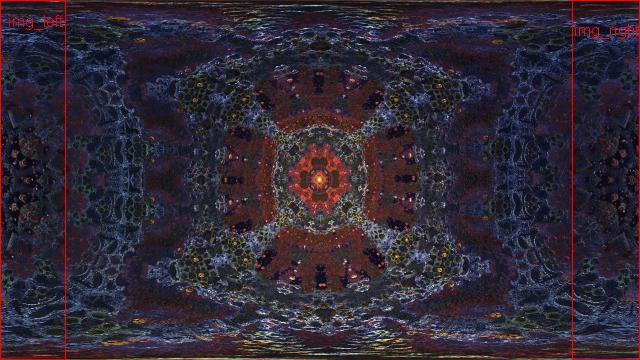

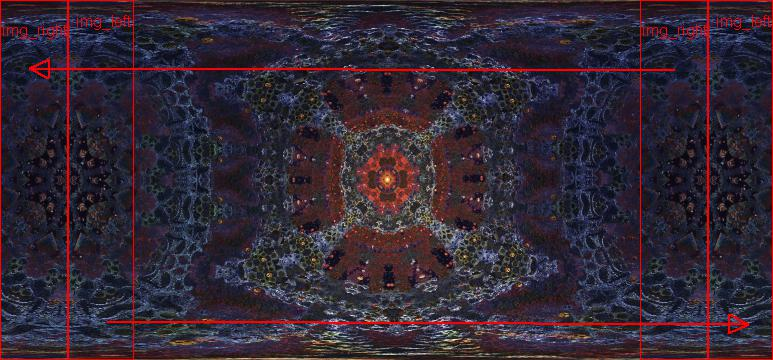

In [7]:
img1 = PIL.Image.open("CaleidoscopeEye4_360_final_upscale2deepdream004500_1.bmp")
showarray(img1)
img2 = PIL.Image.open("CaleidoscopeEye4_360_final_upscale2deepdream004500_2.bmp")
showarray(img2)

In [7]:
def add_border(img):
  width_sourceimg, height_sourceimg = img.size        #Get dimensions original 4K image 3840x2160 ; don't get in conflict with global variables width,height
  #add a 448 pixel wide left and right border to the first image so our original panorama image continues
  #448=2*224 = learning image size of the neuronal network, other sizes should also work
  img_left = img.crop((0,0,448,height_sourceimg))                                    #extract 448 x 2160 stripe from left side
  img_right = img.crop((width_sourceimg-448,0,width_sourceimg,height_sourceimg))    #extract 448 x 2160 stripe from right side
  #new temporary image that can hold the original image plus the two 448 pixel wide stripes
  img_left_right_border = PIL.Image.new('RGB', (width_sourceimg+2*448, height_sourceimg), (0, 0, 0))
  img_left_right_border.paste(img_right,(0,0))        #add the right strip to the left side so it continues panorama
  img_left_right_border.paste(img,(448,0))            #original image in the middle
  img_left_right_border.paste(img_left,(width_sourceimg+448,0)) #add the left strip to the right side so it continues panorama (width+2*448-448 = +448)
  return img_left_right_border


## <span style="color: blue;">schizo604:</span>
<span style="color: blue;">This is the main method that produces a dreamversion of a 4K panoramic image sequence.<br>
<br>
Dreaming is done on 3 levels of images size. So I continue the octave idea of the deepdream method. That way you create bigger structures at level 1 and 2 and smaller structures at level 2 and 3. This makes the dream image more interesting and also fractal like because the bigger structures repeat as smaller structures.
</span>


* <span style="color: blue;">Level 1 has a quarter resolution as the 4K original, so it is 960 x 540 pixel. This level uses the deep dream the standard way with 4 octaves and 20 iterations.</span>
* <span style="color: blue;">Level 2 has half the resolution as the 4K original, so it is 1920 x 1080 pixel. This level uses an own special rendering trick with just 1 octave and 2 iterations. More on that some lines later.</span>
* <span style="color: blue;">Level 3 has the original 4K resolution, so it is 3840 x 2160 pixel. This level uses also the special rendering trick with just 1 octave and 2 iterations.</span>
* <span style="color: blue;">Between level 2 and level 3 I mix with 35% the level 3 image from the previous pass. This helps to keep the small 4K dream details more stable. Else they change and flicker too much.</span>

<span style="color: blue;">**Special big image deepdream rendering trick:**<br>
My python already crashes at level 2 because of memory limits. I use CUDA and so I render with my Nvidia GeForce GTX970. This is much fast than with my fast CPU, so only GPU rendering makes 4K animations possible.<br>
So how to get rid the memory problem? The solution came from [Dreaming big - a blog post by Joseph Smarr](http://josephsmarr.com/2016/02/09/dreaming-big/), who got it from the deep dream authors:<br>
*"The solution to both problems (as suggested to me by the deep dream authors) was to iteratively select small sub-tiles of the image and dream on them separately before merging them back into the final image. By randomly picking the tile offsets each time and iterating for long enough, the whole image gets affected without obvious seams, yet each individual dreaming run is manageable."*<br>
So I did exactly that:<br>
Level 2: dream 100 times a random 448 x 448 square of the image, every area is covered around 10 times in level 2 dreaming loop<br>
Level 3: dream 200 times a random 448 x 448 square of the image, every area is covered around 5 times in level 3 dreaming loop<br>
Hint 1:<br>
I used the set_random_generator method. That makes also the selection / coordinates of the 448 x 448 squares reproducable and so also the whole dream process reproduceable.<br>
Hint 2:<br>
Areas around the borders of the image has a lower chance of beeing inside a square with random coordinates. That way they are  less dreamy. Using the add_border method nearly kills that problem for left and right border. Top and bottom area beeing less dreamy is not a bug, but a feature. The dream itself is not 360° panoramic, so when viewed as a 360° video you get distortions at top and bottom. Less dreams = less distortions :-)
<br>
</span>

<span style="color: blue;">**Postprocessing:**<br>
By using the add_border method the dream at left side and right side are quite similar, but they are not completly similar. Thats why I blend both areas using a vertical black to white gradient of 896x2160. Extract both areas, blend them, copy the result back to both sides so they are equal. This results in a smooth transition and a better panoramic effect.<br>
The I mixed the dream image a bit with the original fractal to bring some of the fractal structure back. I used the fractal image also as an alpha mask so the fractal is more visible at the parts where the fractal is light and keeps the dream at the darker parts alive.<br>
At that blending step I also added a gradient to the aplha mask at top and a mirrored one at bottom. Using this technique makes the panoramic fractal more visible at top and bottom and hides the non-panoramic dream at these areas.<br>
After all postprocessing is done the image is saved.
<br>
</span>

<span style="color: blue;">**Mixing with next frame:**<br>
The postprocessing works on the level 3 image at its own branch. The loop itself used the level 3 image and blends it with the next fractal source image. Next image is blended in with just 30%. Higher percentage may make the dream itself less stable.
<br>
</span>

<span style="color: blue;">Thats it. As a small helper I finally save the last dreamed image already blended with the next one, but without border. That helps to continuing animation between each call of create_dreamsequence, because you can use it as the first input image.<br>
<br>
You can configure the create_dreamsequence method quite well via its parameters, but some in my case static values like blending values are still hard coded and you can experiment with them.</span>

In [8]:
def create_dreamsequence(img,
                         nr_of_frames=100,
                         end='inception_5b/5x5_reduce',
                         level_1_iter_n=20,
                         level_2_loops=100,
                         level_3_loops=200,
                         startfilecounter=1,
                         sourcefolder='4K_source/',
                         sourcefilename='CaleidoscopeEye4_360_final',
                         destfolder='4K_finaldream',
                         destfilename='CaleidoscopeEye4_360_dream_final'):

  #convert the frame into an array and initialize frame counter
  frame = np.float32(img)
  filecounter = startfilecounter

  for i in xrange(nr_of_frames):
    #store the 4K full-size dream image for a later additional blend to keep the fine 4K details mores stable ; at first frame it is simply a copy of the original undreamed first image
    img_level_3_blend = PIL.Image.fromarray(np.uint8(frame))
    
    ### Level 1 ##########
    #quarter-size image (960 x 540) for beginning at level 1 of dream process
    #resize 3-dimensional array at x and y-axis ; z=3 layers for RGB is constant
    frame = nd.affine_transform(frame, [4,4,1], [0,0,0], [height/4,width/4,3], order=1)
    #dream the first small image as a whole with 10 iteration and 4 octaves like in the original deepdream code
    frame=deepdream(net, frame, iter_n=level_1_iter_n, octave_n=4, octave_scale=1.4, end=end)
    
    ### Level 2 ##########
    #level_2 image is an upscaled (0.5) version of level_1-dream 1920 x 1080
    height_level_2 = height/2
    width_level_2 = width/2
    frame = nd.affine_transform(frame, [0.5,0.5,1], [0,0,0], [height_level_2,width_level_2,3], order=1)
    img_level_2 = PIL.Image.fromarray(np.uint8(frame))
    
    #dream level 2 loop
    #100 times a 448 x 448 square dream on a 1920 x 1080 image -> every area is covered around 10 times in level 2 dreaming loop
    for i in xrange(level_2_loops):
      #get random left upper corner of our 448 x 448 dream square, which should completly cover the image
      x = np.random.randint(width_level_2-448)
      y = np.random.randint(height_level_2-448)
      #copy the square
      part_dream = img_level_2.crop((x,y,x+448,y+448))
      frame = np.float32(part_dream)
      #dream on the square slightly with just 2 iterations and 1 octave = 448 x 448 full size
      frame=deepdream(net, frame, iter_n=2, octave_n=1, end=end)
      part_dream = PIL.Image.fromarray(np.uint8(frame))
      #paste the dreamed square hard on the source, blending is not necessary because we just sligtly dreamed, you will see no borders
      img_level_2.paste(part_dream,(x,y))
    
    #optional: mix with upscaled level1-dream to get some of the bigger dream objects from level 1 back
    #img_level_2 = PIL.Image.blend( img_level_2, img_level_2_predream, 0.4 );
    
    ### Level 3 ##########
    #level_3 image is an upscaled version of level_2-dream resulting in start 4K resolution 3840 x 2160
    frame = np.float32(img_level_2)
    frame = nd.affine_transform(frame, [0.5,0.5,1], [0,0,0], [height,width,3], order=1)
    img_level_3 = PIL.Image.fromarray(np.uint8(frame))
    
    #optional-origmix: blend with original image first to get more details into the dream process
    img_level_3 = PIL.Image.blend( img_level_3, img_level_3_blend, 0.35 )
    
    #dream level 3 loop
    #200 times a 448 x 448 square dream on a 3840 x 2160 image -> every area is covered around 5 times in level 3 dreaming loop
    for i in xrange(level_3_loops):
      #get random left upper corner of our 448 x 448 dream square, which should completly cover the image
      x = np.random.randint(width-448)
      y = np.random.randint(height-448)
      #copy the square
      part_dream = img_level_3.crop((x,y,x+448,y+448))
      frame = np.float32(part_dream)
       #dream on the square slightly with just 2 iterations and 1 octave = 448 x 448 full size
      frame=deepdream(net, frame, iter_n=2, octave_n=1, end=end)
      part_dream = PIL.Image.fromarray(np.uint8(frame))
      #paste the dreamed square hard on the source, blending is not necessary because we just sligtly dreamed, you will see no borders
      img_level_3.paste(part_dream,(x,y))
    
    ### Panorama postprocessing - start ##########
    #blend left and right border to kill the panorama break
    img_left = img_level_3.crop((0,0,896,height))               #extract 2*448pixel left image = 2 times width of left border
    img_right = img_level_3.crop((width-896,0,width,height))    #extract 2*448pixel right image = 2 times width of right border
    img_mix = PIL.Image.composite(img_left,img_right,img_border_blend_mask)     #mix using a black-to-white gradient image
    img_level_3.paste(img_mix,(0,0))            #put the mixed image on left side
    img_level_3.paste(img_mix,(width-896,0))    #put the mixed image on right side
    
    #crop 4K panoramic image without left and right border
    panocrop = img_level_3.crop((448,0,width-448,height))
    #mix a bit with the original fractal using the fractal itself also as an alpha mask
    img_current = PIL.Image.open("%s%s%06d.jpg"%(sourcefolder,sourcefilename,filecounter))
    img_current_mask = img_current.copy()
    img_current_mask = PIL.Image.blend( img_current_mask, img_4kblack, 0.8 )   #make the mask much darker so we only add a little bit of the original image to the dreamed image
    img_current_mask.paste(img_border_blend_top,(0,0))      #paste fade to white border on top
    img_current_mask.paste(img_border_blend_bottom,(0,1998))      #paste fade to white border at bottom (1998+162=2160p)
    img_current_mask = img_current_mask.convert('L')
    panocrop = PIL.Image.composite(img_current,panocrop,img_current_mask)
    #save the final image
    panocrop.save("%s%s%06d.jpg"%(destfolder,destfilename,filecounter))
    ### Panorama postprocessing - end ##########
    
    ### mix with next undreamed source image ##########
    frame_next = filecounter+1
    img_next = PIL.Image.open("%s%s%06d.jpg"%(sourcefolder,sourcefilename,frame_next))
    
    #add left and right border to next image so it matches in size with our dream images
    img_next = add_border(img_next)
    
    #blend with the next image - next image just added with 30%
    img_level_3 = PIL.Image.blend( img_level_3, img_next, 0.3 ) 
    #img_level_3.save("%sCaleidoscopeEye4_360_dreamed_blend%06d.jpg"%(destfolder,filecounter))
    
    frame = np.float32(img_level_3)
    filecounter += 1
    
    #additional small zoom - makes the small dream artefacts less stable so turn it off
    #s = 0.001 # scale coefficient
    #frame = nd.affine_transform(frame, [1-s,1-s,1], [height*s/2,width*s/2,0], order=1)

  #save to disc: last dreamed image already blended with the next one, but without border - helps continuing animation
  filecounter -= 1
  panocrop = img_level_3.crop((448,0,width-448,height))
  panocrop.save("%s%s%06d_last_frame.jpg"%(destfolder,destfilename,filecounter))
  
  #return last dreamed image already blended with the next one, we need this as source for the next dream
  return frame

## <span style="color: blue;">schizo604:</span>
<span style="color: blue;">This is the **MAIN METHOD** that is the entry point for the whole dream process.<br>
I dreams on the fractal animation with various dream modes by calls to create_dreamsequence.<br>
The blending between two modes is done in a quite special way:</span>
* <span style="color: blue;">create a fadeout sequence that fades the first dream animation to the original fractal, so the dream vanishes and last frame is a nearly undreamed fractal</span>
* <span style="color: blue;">start to dream on that fadeout sequence with the second dream mode</span>
* <span style="color: blue;">mix the first dream animation (not the fadeout sequence) with the second dream on the fadeout sequence. fadeout sequence can be dumped, you just need it for a smoother start of the next dream mode.</span>
* <span style="color: blue;">here you could break rendering and continue later</span>
* <span style="color: blue;">continue with the second dream mode on the undreamed fractal starting at the end of the fadeout sequence and so on</span>

In [ ]:
#Main-Program

#Initialization

set_random_generator()

#some static alpha images for blendigng operations

#a 896 x 2160 pixel gradient alpha masks for border blend
img_border_blend=PIL.Image.open('img_border_blend.jpg')
img_border_blend_mask=img_border_blend.convert('L')

#a 3840 x 162 pixel gradient alpha masks for top border blend
img_border_blend_top=PIL.Image.open('img_border_blend_top.jpg')

#a 3840 x 162 pixel gradient alpha masks for bottom border blend
img_border_blend_bottom=PIL.Image.open('img_border_blend_bottom.jpg')

#a 3840 x 2160 black image to darken the alpha mask
img_4kblack=PIL.Image.open('img_4kblack.jpg')

sourcefolder = 'D:/DeepDream/360_Tutorial/4K_source/'
destfolder = 'D:/DeepDream/360_Tutorial/4K_finaldream/'
tempfolder = 'D:/DeepDream/360_Tutorial/4K_tempblend/'

#first image
img = PIL.Image.open('%sCaleidoscopeEye4_360_final_upscale2deepdream000001.jpg'%sourcefolder)
img = add_border(img)
width, height = img.size   #Get new dimensions of 4K image with left and right border stripes (in our case 4736 x 2160)

#lets start the first dream sequence of 400 frames
p_nr_of_frames=400
p_end='inception_5b/5x5_reduce'
p_level_1_iter_n=20
p_level_2_loops=100
p_level_3_loops=300
p_startfilecounter=1
p_sourcefolder=sourcefolder
p_sourcefilename='CaleidoscopeEye4_360_final_upscale2deepdream'
p_destfolder=destfolder
p_destfilename='CaleidoscopeEye4_360_dream_final'
last_frame = create_dreamsequence(img,p_nr_of_frames,p_end,p_level_1_iter_n,p_level_2_loops,p_level_3_loops,p_startfilecounter,p_sourcefolder,p_sourcefilename,p_destfolder,p_destfilename)

#create fadeout to original source sequence (create 200 fadeout frames 201..400)
blend_img_sequences(200,201,p_destfolder,p_destfilename,p_sourcefolder,p_sourcefilename,tempfolder,'CaleidoscopeEye4_360_dream_final_fade2source')

set_random_generator()

#also start at image 201 and render 200 images 201..400
img=PIL.Image.open('%sCaleidoscopeEye4_360_dream_final_fade2source000201.jpg'%tempfolder)
img = add_border(img)

#next dream-mode on fadeout sequence
#200-1 = 199 frames to calculate ; also start at image 201, so the last blend2next to 400 is ok 201..399
p_nr_of_frames=199
p_end='inception_4c/5x5'
p_level_1_iter_n=20
p_level_2_loops=100
p_level_3_loops=300
p_startfilecounter=201
p_sourcefolder=tempfolder
p_sourcefilename='CaleidoscopeEye4_360_dream_final_fade2source'
p_destfolder=tempfolder
p_destfilename='CaleidoscopeEye4_360_next_dream'
last_frame = create_dreamsequence(img,p_nr_of_frames,p_end,p_level_1_iter_n,p_level_2_loops,p_level_3_loops,p_startfilecounter,p_sourcefolder,p_sourcefilename,p_destfolder,p_destfilename)

#mix sequences: previous dream A vs. next dream B on fade2source
#200-1 = 199 frames to blend ; also start at image 201..399
#these blend-frames amixb should replace the already rendered dream A frames 201..399 (we need them only for blending)
p_destfolder=destfolder
p_destfilename='CaleidoscopeEye4_360_dream_final'
blend_img_sequences(199,201,p_destfolder,p_destfilename,tempfolder,'CaleidoscopeEye4_360_next_dream',destfolder,'CaleidoscopeEye4_360_dream_final_amixb')

#here you could do a  break and later load the last saved helper image instead of getting it from last_frame return image

set_random_generator()

#input for next dream-mode
img = PIL.Image.fromarray(np.uint8(last_frame))

#create_dreamsequence with new dreammode end=inception_4c/5x5 ; start at frame 400
p_nr_of_frames=300
p_end='inception_4c/5x5'
p_level_1_iter_n=20
p_level_2_loops=100
p_level_3_loops=300
p_startfilecounter=400
p_sourcefolder=sourcefolder
p_sourcefilename='CaleidoscopeEye4_360_final_upscale2deepdream'
p_destfolder=destfolder
p_destfilename='CaleidoscopeEye4_360_dream_final_seq2_'
last_frame = create_dreamsequence(img,p_nr_of_frames,p_end,p_level_1_iter_n,p_level_2_loops,p_level_3_loops,p_startfilecounter,p_sourcefolder,p_sourcefilename,p_destfolder,p_destfilename)



#create fadeout to original source sequence (create 200 fadeout frames 501..700)

## <span style="color: blue;">schizo604:</span>
<span style="color: blue;">Helper Method: I used this post processing method after the complete dream rendering was finished. Despite some special tricks to keep the fine detailed 4K dreams stable there still was some flickering of the dream images. So I decided to mix each image (0) with its neighbours. 3 neighbours backwards (-3,-2,-1) and 3 neighbours forward (1,2,3). Near neighbours (-1,1) have a bigger influence than far neighbours (-3,3).<br>
The result was satisfying, the dream more fluid.<br>
Disadvantage: The original fractal gets blured. More at fast moving parts, not so much at stable parts. Thats why I decided to mix the original fractal image after the neighbour mixing again to the neighbour result using a blendmask. The blendmask is based on the fractal so again the fractal is mixed in more intense where the fractal is visible well and not so much where the fractal is dark.</span>

In [ ]:
#----- 3 neighbour mixing and mixing with original

frame_i_minus_3 = 1
frame_i_minus_2 = 2
frame_i_minus_1 = 3
frame_i_current = 4
frame_i_plus_1 = 5
frame_i_plus_2 = 6
frame_i_plus_3 = 7

originalfolder = 'D:/DeepDream/360_Tutorial/4K_source/'
sourcefolder = 'D:/DeepDream/360_Tutorial/4K_finaldream/_final/'
blendmapfolder = 'D:/DeepDream/360_Tutorial/4K_blendmap/'
destfolder1 = 'D:/DeepDream/360_Tutorial/4K_finaldream/_final_mixed/'
destfolder2 = 'D:/DeepDream/360_Tutorial/4K_finaldream/_final_mixed_with_original/'

for i in xrange(5550):
  img_minus_3 = PIL.Image.open("%sCaleidoscopeEye4_360_dream_final%06d.jpg"%(sourcefolder,frame_i_minus_3))
  img_minus_2 = PIL.Image.open("%sCaleidoscopeEye4_360_dream_final%06d.jpg"%(sourcefolder,frame_i_minus_2))
  img_minus_1 = PIL.Image.open("%sCaleidoscopeEye4_360_dream_final%06d.jpg"%(sourcefolder,frame_i_minus_1))
  img_current = PIL.Image.open("%sCaleidoscopeEye4_360_dream_final%06d.jpg"%(sourcefolder,frame_i_current))
  img_plus_1 = PIL.Image.open("%sCaleidoscopeEye4_360_dream_final%06d.jpg"%(sourcefolder,frame_i_plus_1))
  img_plus_2 = PIL.Image.open("%sCaleidoscopeEye4_360_dream_final%06d.jpg"%(sourcefolder,frame_i_plus_2))
  img_plus_3 = PIL.Image.open("%sCaleidoscopeEye4_360_dream_final%06d.jpg"%(sourcefolder,frame_i_plus_3))
  img_current_original = PIL.Image.open("%sCaleidoscopeEye4_360_final_upscale2deepdream%06d.jpg"%(originalfolder,frame_i_current))
  img_current_blendmap = PIL.Image.open("%sCaleidoscopeEye4_360_final_upscale2deepdream%06d.jpg"%(blendmapfolder,frame_i_current))
  mask_blendmap=img_current_blendmap.convert('L')

  img_minus_mix = PIL.Image.blend( img_minus_2, img_minus_3, 0.35 )
  img_minus_mix = PIL.Image.blend( img_minus_1, img_minus_mix, 0.42 )
  img_minus_mix = PIL.Image.blend( img_current, img_minus_mix, 0.5 )

  img_plus_mix = PIL.Image.blend( img_plus_2, img_plus_3, 0.35 )
  img_plus_mix = PIL.Image.blend( img_plus_1, img_plus_mix, 0.42 )
  img_plus_mix = PIL.Image.blend( img_current, img_plus_mix, 0.5 )

  img_current = PIL.Image.blend( img_minus_mix, img_plus_mix, 0.5 )
  img_current.save("%sCaleidoscopeEye4_360_dream_final_mixed%06d.jpg"%(destfolder1,frame_i_current))

#  img_current_with_original = PIL.Image.blend( img_current, img_current_original, 0.2 )
  img_current_with_original = PIL.Image.composite(img_current, img_current_original, mask_blendmap)
  img_current_with_original.save("%sCaleidoscopeEye4_360_dream_final_mixed_with_original%06d.jpg"%(destfolder2,frame_i_current))

  frame_i_minus_3 += 1
  frame_i_minus_2 += 1
  frame_i_minus_1 += 1
  frame_i_current += 1
  frame_i_plus_1 += 1
  frame_i_plus_2 += 1
  frame_i_plus_3 += 1

## <span style="color: blue;">schizo604:</span>
<span style="color: blue;">Helper Method: You can use this short code snippet to dream on a single 4K (3840x2160) image.</span>

In [17]:
#single 4K image rendering
set_random_generator()

sourcefolder = 'D:/'
destfolder = 'D:/'
tempfolder = 'D:/'


#first image
img = PIL.Image.open('%sCaleidoscopeEye000001_2K.jpg'%sourcefolder)
width, height = img.size   #Get new dimensions of 4K

#lets start the first dream sequence
p_nr_of_frames=1
p_end='inception_5b/5x5_reduce'
p_level_1_iter_n=160
p_level_2_loops=300
p_level_3_loops=300
p_startfilecounter=1
p_sourcefolder=sourcefolder
p_sourcefilename='CaleidoscopeEyes'
p_destfolder=destfolder
p_destfilename='CaleidoscopeEye_dream_final'
last_frame = create_dreamsequence(img,p_nr_of_frames,p_end,p_level_1_iter_n,p_level_2_loops,p_level_3_loops,p_startfilecounter,p_sourcefolder,p_sourcefilename,p_destfolder,p_destfilename)


0 1 inception_5b/5x5_reduce (448L, 448L, 3L)
